<h6> Import all the libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

<h6> Move to the location where all the images exist -- they should be in dated folders just like on the drive

In [3]:
import os
import cv2
os.chdir(r"D:\MACHINE_LEARNING\bacteriaLSTM")

data = []
IMG_SIZE = 128

path = r"D:/MACHINE_LEARNING/bacteriaLSTM/"

<h6> The cell below creates data in form of movies ie. each folder is a movie of bacteria growth

In [2]:


def create_data():   
    count = 0
    for folder in os.listdir(path):
        _ = []
        print("FOLDER: ",folder)
        for filename in os.listdir(path + folder):
            if(".JPG" in filename): 
                temp_path = path + folder + "/" + filename
                count += 1
                try:
                    img_array = cv2.imread(temp_path)
                    img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                    _.append(img_array/255.0)
                    print("image processed..." + str(count) , end="\r")
                
                except Exception as e:
                    pass
        data.append(_)         
create_data()

FOLDER:  2021-02-27
FOLDER:  2021-03-010
FOLDER:  2021-03-030
FOLDER:  2021-03-041
FOLDER:  2021-03-0836
FOLDER:  2021-03-0957
FOLDER:  2021-03-1080
FOLDER:  2021-06-2141
FOLDER:  2021-06-2316
FOLDER:  2021-06-2587
FOLDER:  2021-06-2863
FOLDER:  2021-06-30034
FOLDER:  2021-07-01135
FOLDER:  2021-07-02232


<h6> Saving the data in pickle so that we don't have to run the create data function every time

In [4]:
import pickle

with open(r"D:\MACHINE_LEARNING\bacteriaLSTMpickle\data.pkl", 'wb') as f:
    pickle.dump(data, f)

<h6> Run the cell below if the pickle is already saved

In [4]:
import pickle

with open(r"D:\MACHINE_LEARNING\bacteriaLSTMpickle\data.pkl", 'rb') as f:
    temp = pickle.load(f)

data = temp

<h6> Displaying random image. First index is the movie number and second is the frame of that movie

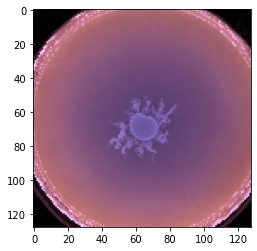

In [5]:
import matplotlib.pyplot as plt

plt.imshow(data[10][5])

<h6> So since we want all movies to be of same length if take out all the alternate frames to make all movies 20 frames long

In [6]:
for index_movie, movie in enumerate(data):
    while(len(movie)>20):
        for index_frame, frame in enumerate(movie):
            del data[index_movie][index_frame]
            if(len(data[index_movie])<=20):
                break

<h6> Shifted data is one frame ahead of unshifted data 

In [7]:
shifted_data = [i[1:] for i in data]
present_data = [i[0:-1] for i in data]
print(len(shifted_data), len(present_data))

14 14


In [8]:
X = np.array(present_data)
X_future = np.array(shifted_data)
print(X.shape)
print(X_future.shape)

(14, 19, 128, 128, 3)
(14, 19, 128, 128, 3)


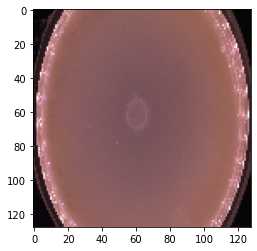

In [9]:
plt.imshow(X[0][0])

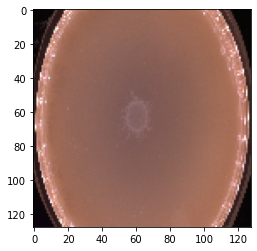

In [10]:
plt.imshow(X_future[0][-1])

<h6> Size of the network is decided by how much my pc could handle without crashing 

In [10]:
seq = keras.Sequential(
[
    keras.Input(shape=(None,IMG_SIZE,IMG_SIZE,3)),
    layers.ConvLSTM2D(filters=128, kernel_size=(3,3), padding="same",return_sequences=True),
    layers.BatchNormalization(),
    layers.ConvLSTM2D(filters=128, kernel_size=(3,3), padding="same",return_sequences=True),
    layers.BatchNormalization(),
    layers.ConvLSTM2D(filters=128, kernel_size=(3,3), padding="same",return_sequences=True),
    layers.BatchNormalization(),
    layers.ConvLSTM2D(filters=128, kernel_size=(3,3), padding="same",return_sequences=True),
    layers.BatchNormalization(),
    layers.Conv3D(filters = 3, kernel_size=(3,3,3), activation="sigmoid", padding='same'),
])
seq.compile(loss='binary_crossentropy', optimizer='adam')

In [12]:
seq.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_4 (ConvLSTM2D)  (None, None, 128, 128, 40 62080     
_________________________________________________________________
batch_normalization_4 (Batch (None, None, 128, 128, 40 160       
_________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)  (None, None, 128, 128, 40 115360    
_________________________________________________________________
batch_normalization_5 (Batch (None, None, 128, 128, 40 160       
_________________________________________________________________
conv_lst_m2d_6 (ConvLSTM2D)  (None, None, 128, 128, 40 115360    
_________________________________________________________________
batch_normalization_6 (Batch (None, None, 128, 128, 40 160       
_________________________________________________________________
conv_lst_m2d_7 (ConvLSTM2D)  (None, None, 128, 128, 40

In [13]:
# Define modifiable training hyperparameters.
epochs = 100
batch_size = 1

noisy_movies, shifted_movies = X, X_future

# Fit the model to the training data.
# Uncomment this if you are retraining the model
# seq.fit(
#     noisy_movies,
#     shifted_movies,
#     batch_size=batch_size,
#     epochs=epochs,
#     verbose=1,
#     validation_split=0.1,
# )

In [14]:
noisy_movies.shape

(14, 19, 128, 128, 3)

<h6> Saving the model go to the last cell to load the saved model instead of training it every time

In [18]:
seq.save('bacteriaLSTMV1')

INFO:tensorflow:Assets written to: bacteriaLSTMV1\assets


In [ ]:
movie_index = 7
track = noisy_movies[movie_index][0:15,::,::,::]

for j in range(20):
    new_pos = seq.predict(track[np.newaxis, ::,::,::,::])
    new = new_pos[::,-1,::,::,::]
    track = np.concatenate((track, new), axis=0)
    
    #And then compare the predictions
    #to the ground truth
    
track2 = noisy_movies[movie_index][::,::,::,::]
for i in range(19):
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(121)
    
    if i>15:
        ax.text(1,3,"Predictions!", fontsize = 20, color="w")
    else:
        ax.text(1,3,"Initial trajectory", fontsize=20)
    toplot = track[i,::,::,0]
    
    plt.imshow(toplot)
    ax = fig.add_subplot(122)
    plt.text(1,3, "Ground trith", fontsize=20)
    
    toplot = track2[i, ::, ::, 0]
    if i>=2:
        toplot =  shifted_movies[movie_index][i - 1, ::, ::, 0]
        
    plt.imshow(toplot)
    plt.savefig("%i_animate.png")

In [11]:
seq = keras.models.load_model("bacteriaLSTMV1")